# Imports

In [2]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn import preprocessing

# for extracting information about the tree
from sklearn.tree import _tree

# for visualising tree
import graphviz

In [3]:
# get working directory
print(os.getcwd())

# change to relevant folder
output_path = "C:/Users/amira/OneDrive - University of Leeds/Projects/Palindrome/Market Segmentation/Code/Output Data/Kenya Composite/"
os.chdir(output_path)
print("Working directory changed to:")
print(output_path)


c:\Users\amira\OneDrive - University of Leeds\Projects\Palindrome\Market Segmentation\Code\datafi_palindrome_segmentation
Working directory changed to:
C:/Users/amira/OneDrive - University of Leeds/Projects/Palindrome/Market Segmentation/Code/Output Data/Kenya Composite/


# Data

### Import dataset and select variables (df)

#### Select variables

In [4]:
# import dataset
data_path = "C:/Users/amira/OneDrive - University of Leeds/Projects/Palindrome/Market Segmentation/Code/Output Data/"
df_load = pd.read_csv(data_path + "DHS_Kenya_chosen_cleaned_all_new_targets.csv")

In [5]:
######## Missing from Kenyan dataset:
#### other_vars
# 'hiv_sample_weight', 
# 'hiv_result', 
#### ordinal_features
# 'used_internet_last_month', 
# 'has_bank_account', 
# 'uses_phone_transactions', 
# 'owns_mobile_phone', 
#### target_vars
# 'medication_payment', 
# 'post_birth_check_source_sector'



### EXTRA INFORMATION
other_vars = [
    ## Geographical
    "district",
    "region", # 'municipality',
    
    # ALSO sample weights etc.
    "dhs_sample_weight",
    "dhs_primary_sampling_unit",
    "dhs_sample_stratum", 
    
    ## HIV vars
    # "hiv_sample_weight",    
    # "hiv_result",

    ## Excluded vars
    "has_health_insurance",  # health insurance now a feature
]


#### FEATURES
# classify vars as ordinal/categorical/numerical
ordinal_features = [
    "gender",
    "age_group_2",
    "urban_rural",
    "employed",
    "wealth_bracket",
    "education_attainment",

    # information access
    # "used_internet_last_month",    
    "watches_tv",
    "listens_radio",
    "reads_newspaper_mag",

    # new context
    "homeowner",
    # "has_bank_account",

    ### (these tank the count from ~10k to ~7k, together ~5k)
    # "has_health_insurance",  # health insurance now a feature
    # "uses_phone_transactions",
    # "used_condom_last",

    # newest vars
    "literacy",
    "sex_of_head",

    # "owns_mobile_phone",
    "ever_heard_of_sti",
    "ever_heard_of_aids",
    "had_sti_past_year",
    "ever_hiv_tested",
    "know_place_hiv_test",
    "heard_of_other_sti",
]
categorical_features = [ # need OneHot
    "ethnicity",

    # new
    # "relationship_to_head", # JUST ENCODES "ADULT OR NOT"?   
    "marital_status",
    # "current_contraceptive_method", # CORRELATES TOO STRONGLY WITH FAMILY PLANNING?
    ]
numeric_features = [
    "n_children_at_home",
    # new
    "years_in_residence",
    "age_of_head",
    "age_at_first_sex",
    ]
feature_vars = ordinal_features + categorical_features + numeric_features

### TARGETS
target_vars = [
    "last_hiv_test_sector",
    ## NEW TARGETS
    # "medication_payment",
    # "dental_care_sector", #TAKE OUT BECAUSE TOO LOW N
    # "sti_advice_sector", #TAKE OUT BECAUSE TOO LOW N
    "family_planning_last_source_sector",
    "family_planning_first_source_sector",
    "antenatal_care_sector",
    "place_of_delivery_sector",
    # "post_birth_check_source_sector",
    "baby_first_check_source_sector",
    # 'baby_fevercough_sector', #TAKE OUT BECAUSE TOO LOW N
]

In [6]:
# select data + SAMPLE WEIGHTS
chosen_vars = other_vars + feature_vars + target_vars 
df = df_load[chosen_vars].copy()
print(list(df.columns))

['district', 'region', 'dhs_sample_weight', 'dhs_primary_sampling_unit', 'dhs_sample_stratum', 'has_health_insurance', 'gender', 'age_group_2', 'urban_rural', 'employed', 'wealth_bracket', 'education_attainment', 'watches_tv', 'listens_radio', 'reads_newspaper_mag', 'homeowner', 'literacy', 'sex_of_head', 'ever_heard_of_sti', 'ever_heard_of_aids', 'had_sti_past_year', 'ever_hiv_tested', 'know_place_hiv_test', 'heard_of_other_sti', 'ethnicity', 'marital_status', 'n_children_at_home', 'years_in_residence', 'age_of_head', 'age_at_first_sex', 'last_hiv_test_sector', 'family_planning_last_source_sector', 'family_planning_first_source_sector', 'antenatal_care_sector', 'place_of_delivery_sector', 'baby_first_check_source_sector']


#### Make new composite target: ever_private (ever interacted with private healthcare)

In [7]:
# convert to single variable with "yes", "no" or NaN entries
public_bool = (df[target_vars] == "public").sum(axis=1) > 0
private_bool = (df[target_vars] == "private").sum(axis=1) > 0

df["ever_private"] = np.select(
    [private_bool, public_bool], ["yes", "no"], default="unknown")
df["ever_private"].replace({"unknown": np.nan}, inplace=True)
df["ever_private"].value_counts()

no     21024
yes     6114
Name: ever_private, dtype: int64

#### Plot availabilities

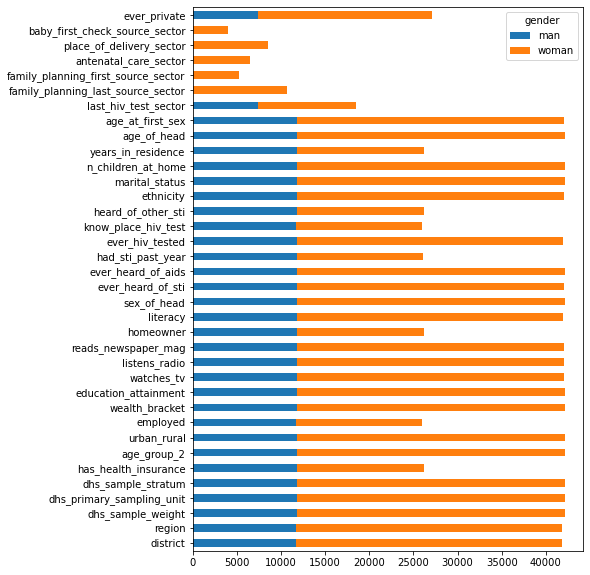

In [8]:
# variable availability
f, ax = plt.subplots(1, 1, figsize=(7, 10))
df.groupby('gender').count().T.plot.barh(stacked=True, ax=ax)
plt.show()

### Drop NAs in features (df_clean)

In [9]:
df_clean = df.dropna(
    subset=feature_vars
).copy()
df_clean.shape

(25559, 37)

# Optimal Decision Tree (ML)

## Data prep

### Get final clean dataset

In [24]:
# # select data
# final_var_list = (
#     ["dhs_sample_weight"]
#     + feature_vars
#     + ["ever_private"]
# )

# df_select = df_clean
# df_select = df_select[final_var_list]
# df_select = df_select.dropna()
# # df_select = df_select.query("gender == 'man'")

In [51]:
# select data
final_var_list = (
    ["dhs_sample_weight"]
    + feature_vars
    # + ['last_hiv_test_sector']
    + ["ever_private"]
)

df_select = df_clean
df_select = df_select[final_var_list]
df_select = df_select.dropna()
df_select = df_select.query("gender == 'woman'")

### Transform dataset to numeric

In [52]:
######## Missing from Kenyan dataset:
#### other_vars
# 'hiv_sample_weight', 
# 'hiv_result', 

#### ordinal_features
# 'used_internet_last_month', 
# 'has_bank_account', 
# 'uses_phone_transactions', 
# 'owns_mobile_phone', 

#### target_vars
# 'medication_payment', 
# 'post_birth_check_source_sector'

In [53]:
def transform_features(df_select):

    ### define orders for ordinal categorical variables
    gender_cats = ["man", "woman"]
    age_cats = ["adolescent", "young adult", "adult", "middle-aged"]
    urban_rural_cats = ["rural", "urban"]
    employed_cats = ["unemployed", "employed"]
    wealth_cats = ["poorest", "poorer", "middle", "richer", "richest"]
    # NEW
    education_cats = [
        "no education",
        "incomplete primary",
        "complete primary",
        "incomplete secondary",
        "complete secondary",
        "higher",
    ]
    no_yes_cats = ["no", "yes"]
    literacy_cats=['cannot read at all', 'able to read only parts of sentence', 'able to read whole sentence']
    sex_cats=['male','female']

    # initialise encoder
    # ORDER IS THE SAME AS IN THE "SELECT VARIABLES" CELL AT THE START OF NOTEBOOK
    ordinal_features_encoder = preprocessing.OrdinalEncoder(
        categories=[
            # "gender",
            gender_cats,           
            # "age_group_2",
            age_cats,
            # "urban_rural",
            urban_rural_cats,         
            # "employed",
            employed_cats,            
            # "wealth_bracket",
            wealth_cats,

            # # NEW
            # "education_attainment",
            education_cats,            
            # "used_internet_last_month",
            # no_yes_cats,

            # # NEW information access
            # "watches_tv",
            no_yes_cats,            
            # "listens_radio",
            no_yes_cats,            
            # "reads_newspaper_mag",
            no_yes_cats,

            # # NEW NEW demographics/contextual
            # "homeowner",
            no_yes_cats,            
            # "has_bank_account",
            # no_yes_cats,
            
            # ### (these tank the count from ~10k to ~7k, together ~5k)
            # # "has_health_insurance",  # health insurance now a feature
            # # no_yes_cats,            
            # "uses_phone_transactions",
            # no_yes_cats,   
            # # "used_condom_last",

            # # new new new
            # "literacy",
            literacy_cats,            
            # "sex_of_head",
            sex_cats,
            
            # "owns_mobile_phone",
            # no_yes_cats,            
            # "ever_heard_of_sti",
            no_yes_cats,            
            # "ever_heard_of_aids",
            no_yes_cats,            
            # "had_sti_past_year",
            no_yes_cats,            
            # "ever_hiv_tested",
            no_yes_cats,            
            # "know_place_hiv_test",
            no_yes_cats,            
            # "heard_of_other_sti",
            no_yes_cats,
            ]
    )

    X_ordinals_df = df_select[ordinal_features].copy()
    # apply encoder
    X_ordinals = ordinal_features_encoder.fit_transform(X_ordinals_df)
    # put back into dataframe mode
    X_ordinals_df[:] = X_ordinals

    # get numerics
    X_numerics = df_select[numeric_features]

    # OneHot encode categoricals
    # (redundancy kept because we want interpretability at the moment, i.e. drop_first=False)
    X_onehot_categoricals = pd.get_dummies(
        df_select[categorical_features], prefix=categorical_features, drop_first=False
    )

    # make sure everything is an integer
    X_df = X_ordinals_df.join([X_numerics, X_onehot_categoricals]).astype(int)

    # fix names (column names need to be valid Python variable names later)
    X_df.columns = X_df.columns.str.replace(" ", "_")
    X_df.columns = X_df.columns.str.replace("-", "_")
    X_df.columns = X_df.columns.str.replace("/", "_slash_")

    return X_df

In [54]:
X_df = transform_features(df_select)

In [55]:
y = df_select["ever_private"].replace({"no": 0, "yes": 1})
# y = df_select["last_hiv_test_sector"].replace({"public": 0, "private": 1})

In [56]:
sample_weights = df_select["dhs_sample_weight"]

## Model

### Fit Decision Tree

In [57]:
print("No. respondents:", sample_weights.shape[0])
print(
    "Sample weight sum divided by no. respondents:",
    sample_weights.sum() / sample_weights.shape[0],
)
print("Smallest sample weight:", sample_weights.min())
print("Biggest sample weight:", sample_weights.max())

No. respondents: 11733
Sample weight sum divided by no. respondents: 1.0165587934032216
Smallest sample weight: 0.031092
Biggest sample weight: 7.497423


In [66]:
0.02*len(y)

234.66

In [67]:
clf = tree.DecisionTreeClassifier(
    # criteria chosen based on:
    # scikit-learn.org/stable/modules/tree.html#complexity
    
    # per split
    min_impurity_decrease=0.0002,

    # minimum segment (leaf) population
    min_weight_fraction_leaf=0.04, #0.03 for men # equiv. to ~200 people per leaf, 0.05 for with HI and 0.03 without
    # or for unweighted, use:
    # min_samples_leaf=200,
)

# fit
clf = clf.fit(X_df, y, sample_weight=sample_weights)

### Export model visualisations

In [68]:
def export_tree_diagrams(rates=True, format='png', view=False):

    # import graphviz
    dot_data = tree.export_graphviz(
        clf,

        feature_names=X_df.columns,
        label="root",

        impurity=False,
        proportion=(True if rates else False),
        precision=(3 if rates else 1),

        filled=True,
        rounded=True,
        special_characters=True,
    )

    graph = graphviz.Source(dot_data)
    graph.render(
        filename=output_path + "Figs/Trees/women_weighted_"+("rates" if rates else "counts"),
        format=format,
        cleanup=True,
        view=view,
    )

In [69]:
# export tree diagrams
export_tree_diagrams(rates=True, format='png')
export_tree_diagrams(rates=True, format='pdf')

export_tree_diagrams(rates=False, format='png')
export_tree_diagrams(rates=False, format='pdf')

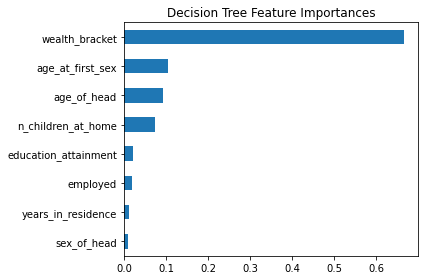

In [72]:
tree_feature_importance_df = pd.DataFrame(
    {"importance": clf.feature_importances_}, index=X_df.columns
).sort_index().sort_values(by="importance",ascending=True)
tree_feature_importance_df_non_zero = tree_feature_importance_df[tree_feature_importance_df["importance"]!=0]

tree_feature_importance_df_non_zero.plot.barh(legend=False)
plt.title("Decision Tree Feature Importances")
plt.tight_layout()
plt.savefig(output_path + "women_tree_importances_weighted.png", dpi=300)

In [75]:
tree_feature_importance_df_non_zero.sort_values(by="importance",ascending=False)

importance
wealth_bracket          0.665830
age_at_first_sex        0.104756
age_of_head             0.091986
n_children_at_home      0.074504
education_attainment    0.022339
employed                0.018237
years_in_residence      0.012810
sex_of_head             0.009538

## Get leaf node info

In [22]:
# LEGACY: Get segment summaries here (instead of after labelling dataset with segment IDs)

# function to get segment summaries (leaf nodes)
# from sklearn.tree import _tree
def get_leaf_nodes_info(tree, feature_names, class_names):
    # code from: 
    # https://stackoverflow.com/questions/30408046/finding-a-corresponding-leaf-node-for-each-data-point-in-a-decision-tree-scikit
    
    tree_ = tree.tree_
    feature_name = [feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]    
    
    recurse(0, path, paths)


    rows = []
    for path in paths:

        row = []
        condition = "if "
        
        for p in path[:-1]:
            if condition != "if ":
                condition += " and "
            condition += str(p)
        
        row.append(condition)

        if class_names is None:
            raise Exception('class_names not provided!')
            #condition += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            row.append(classes[0])
            row.append(classes[1])
        
        rows.append(row)
    
    segments_df = pd.DataFrame(rows, columns=['condition','n_public','n_private'])
    segments_df['n_total'] = segments_df['n_public'] + segments_df['n_private']
    
    return segments_df

In [23]:
df_leaf_info = get_leaf_nodes_info(clf,X_df.columns,['no','yes'])

# get whole sample populations
sample_total_positive = df_leaf_info['n_private'].sum()
sample_total_n = df_leaf_info['n_total'].sum()
# calculate ratios
df_leaf_info['%_segment_ever_private'] = df_leaf_info['n_private']/df_leaf_info['n_total']*100.0
df_leaf_info['pop_%'] = df_leaf_info['n_total']/sample_total_n*100.0

df_leaf_info.to_csv(output_path+'df_leaf_info_unweighted.csv')

## Get each respondent's segment allocation

### 1. Get tree as useable python code to find each row's segment

In [24]:
###### function to get Python code to find out each respondent's leaf node (segment) allocation from the tree ######
# from: stackoverflow.com/a/39772170/11802790
# Amir mods:
# resulting function takes in list of feature names as opposed to individual feature names
# returns leaf node id instead of "tree_.value[node]"

# from sklearn.tree import _tree
def tree_to_code(tree, feature_names):

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    # make these local
    global leaf_id
    global tree_code
    # set first leaf_id
    leaf_id = 0
    # initialise string
    tree_code = "def tree_as_func(X_row):"
    tree_code += "\n  {} = X_row".format(", ".join(feature_names))
    tree_code += "\n"

    def recurse(node, depth):
        # make these local
        global leaf_id
        global tree_code
        indent = "  " * depth

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            tree_code += "\n{}if {} <= {}:".format(indent, name, threshold)
            recurse(tree_.children_left[node], depth + 1)
            tree_code += "\n{}else:  # if {} > {}".format(indent, name, threshold)
            recurse(tree_.children_right[node], depth + 1)
        else:
            tree_code += "\n{}return {}".format(indent, leaf_id)  # tree_.value[node]
            leaf_id += 1

    recurse(0, 1)

    ## no need to return anything as tree_code is global for now. Change this. ##

In [25]:
# run the above and save resulting Python code to file
# (to be imported as a function)

tree_to_code(clf, X_df.columns)
with open(output_path + "tree_code_saved.py", "w") as f:
    f.write(tree_code)


In [26]:
# import resulting function into this script
from tree_code_saved import tree_as_func

tree_as_func

<function tree_code_saved.tree_as_func(X_row)>

### 2. Get each person's segment allocation and save to file alongside cleaned dataset

for maximum coverage use ORIGINAL dataset: select features and drop NAs (NAs in target ignored).

In [27]:
df_features_clean = df[
    # choose features and sample weights only
    feature_vars
    + ["dhs_sample_weight"]
# drop NAs
].dropna()

# transform to numeric so tree can ingest
X_df_all = transform_features(df_features_clean).to_numpy()

# get segment ID that corresponds to each person in this dataset
segment_ids_all = pd.DataFrame({'segment_id':[tree_as_func(x) for x in X_df_all]}, index=df_features_clean.index)

# add info re. whether person was in training dataset (i.e. with target)
segment_ids_all['in_training_dataset'] = 0
segment_ids_all.loc[df_select.index, 'in_training_dataset'] = 1

# save to file
segment_ids_all.to_csv(output_path+'df_segment_allocations.csv')

In [28]:
# and add segment ID variable to dataset
# df_features_clean.insert(0, "in_training_dataset", segment_ids_all["in_training_dataset"])
# df_features_clean.insert(0, "segment_id", segment_ids_all["segment_id"])

# add targets back into dataset (many NAs in targets here)
df_with_segment_IDs = (
    segment_ids_all.join(df[other_vars], how="inner")
    .join(df_features_clean.drop('dhs_sample_weight',axis=1), how="inner")
    .join(df[target_vars], how="inner")
    .join(df_clean["ever_private"], how="inner")
)

# save to file
df_with_segment_IDs.to_csv(output_path+'df_with_ever_private_segment_IDs_NEW.csv')

# Basic Plots

## Explore target availabilities

In [ ]:
def get_weighted_value_rates(variable_name, df=df):
    weighted_value_counts = df.groupby(variable_name)['dhs_sample_weight'].sum().sort_values()

    weighted_total_count = weighted_value_counts.sum()
    weighted_value_rates = weighted_value_counts/weighted_total_count

    return weighted_value_rates

In [ ]:
# df[target_vars].dropna(thresh=6)

In [ ]:
# before dropping NAs in features
target_counts = df.count()[target_vars+['ever_private']]
percs = [df[target].value_counts().iloc[1]*100 for target in target_vars+['ever_private']] / target_counts

target_rates_df = pd.DataFrame(
    {"n respondents": target_counts, "private_%": np.round(percs,1)}, 
    index=target_vars+['ever_private']
)

target_rates_df

n respondents  private_%
last_hiv_test_sector                          8941       11.4
medication_payment                            2497       24.1
family_planning_last_source_sector            3838       16.4
family_planning_first_source_sector           3216       15.7
antenatal_care_sector                         2761        9.2
place_of_delivery_sector                      2788        7.6
post_birth_check_source_sector                1805        7.5
baby_first_check_source_sector                2393        6.3
ever_private                                 10737       19.5

In [ ]:
# before dropping NAs in features but with SAMPLE WEIGHTS
target_counts = df.count()[target_vars+['ever_private']]
percs = [get_weighted_value_rates(target, df=df).iloc[0]*100 for target in target_vars+['ever_private']]

target_rates_df = pd.DataFrame(
    {"n respondents": target_counts, "private_%": np.round(percs,1)}, 
    index=target_vars+['ever_private']
)

target_rates_df

n respondents  private_%
last_hiv_test_sector                          8941       12.5
medication_payment                            2497       26.7
family_planning_last_source_sector            3838       18.4
family_planning_first_source_sector           3216       17.8
antenatal_care_sector                         2761       11.3
place_of_delivery_sector                      2788        9.3
post_birth_check_source_sector                1805        9.1
baby_first_check_source_sector                2393        7.7
ever_private                                 10737       20.6

In [ ]:
# after dropping NAs in features
target_counts = df_clean.count()[target_vars+['ever_private']]
percs = [df_clean[target].value_counts().iloc[1]*100 for target in target_vars+['ever_private']] / target_counts

target_rates_df_clean = pd.DataFrame(
    {"n respondents": target_counts, "private_%": np.round(percs,1)}, 
    index=target_vars+['ever_private']
)

target_rates_df_clean

n respondents  private_%
last_hiv_test_sector                          7664       11.8
medication_payment                             964       23.4
family_planning_last_source_sector            3286       16.7
family_planning_first_source_sector           2736       16.0
antenatal_care_sector                         2293        9.8
place_of_delivery_sector                      2307        7.9
post_birth_check_source_sector                1509        7.8
baby_first_check_source_sector                1989        6.4
ever_private                                  7905       19.3

In [ ]:
# after dropping NAs in features but with SAMPLE WEIGHTS
target_counts = df_clean.count()[target_vars+['ever_private']]
percs = [get_weighted_value_rates(target, df=df_clean).iloc[0]*100 for target in target_vars+['ever_private']]

target_rates_df = pd.DataFrame(
    {"n respondents": target_counts, "private_%": np.round(percs,1)}, 
    index=target_vars+['ever_private']
)

target_rates_df

n respondents  private_%
last_hiv_test_sector                          7664       12.9
medication_payment                             964       27.5
family_planning_last_source_sector            3286       18.4
family_planning_first_source_sector           2736       17.9
antenatal_care_sector                         2293       11.8
place_of_delivery_sector                      2307        9.7
post_birth_check_source_sector                1509        9.3
baby_first_check_source_sector                1989        7.9
ever_private                                  7905       21.2

In [ ]:
target_rates_df.to_csv(output_path+'target_availabilities.csv')

In [ ]:
# df_data_availabilities = pd.DataFrame()

# df_data_availabilities['subset'] = [
#     'Survey*', 
#     'Predictors response', 
#     'HIV test facility response', 
#     'Health insurance response', 
#     'Both targets response']

# df_data_availabilities['count'] = [
#     df.count()['gender'],
#     df_features_clean.count()['gender'],
#     df_no_HI_clean['last_hiv_test_sector'].count(),
#     df_no_tests_clean['has_health_insurance'].count(),
#     df_clean.count()['has_health_insurance']]

# plt.figure(figsize=(5,4))
# ax=sns.barplot(x='subset',y='count',data=df_data_availabilities)

# plt.bar_label(ax.containers[0])
# plt.ylim(0,13000)

# plt.xlabel('')
# plt.ylabel('No. people')
# plt.xticks(rotation=25,ha='right')
# plt.tight_layout()

# plt.savefig(
#     output_path+'Figs/data_availability.png',
#     dpi=300,
#     facecolor='white', transparent=False)

NOTE:
- Possible chance differences in reponses to the health insurance question is because of different samples - check with survey

## Variable Histograms

#### Variable histogram maker function

In [ ]:
def variable_hists_vert(
    data, 
    var_name:str, var_label:str, 
    ordered_values:list, 
    ylim=None,
    file_suffix=None,
    xticks_rotation=None,
    xticks=None,
    **plt_kwargs
    ):

    grid = sns.catplot(
        x=var_name,
        data=data,
        kind='count',
        order=ordered_values,
        **plt_kwargs)

    # add barplot values
    ax = grid.axes[0,0]
    plt.bar_label(ax.containers[0])    
    
    if ylim:
        plt.ylim(0,ylim)
    
    plt.ylabel('No. people')
    plt.xlabel(var_label)
    if xticks_rotation:
        plt.xticks(rotation=xticks_rotation,ha='right')
    if xticks:
        locs, labels = plt.xticks()
        plt.xticks(locs, labels=xticks)

    plt.tight_layout()
    plt.savefig(
        output_path+'Figs/Hists/'+var_name+('_'+file_suffix if file_suffix else '')+'.png',
        dpi=300,
        facecolor='white', transparent=False)

#### Create histograms for all variables

In [ ]:
age_group_2_ordered_values = ["adolescent", "young adult", "adult", "middle-aged"]

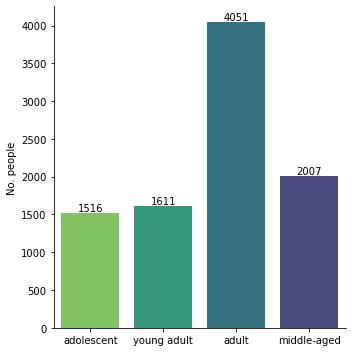

In [ ]:
variable_hists_vert(
    df_clean, "age_group_2", "", age_group_2_ordered_values, palette="viridis_r"
)


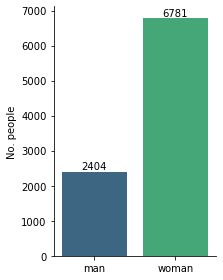

In [ ]:
variable_hists_vert(
    df_clean, 
    "gender", 
    "", 
    ["man", "woman"], 
    height=4, 
    aspect=0.8, 
    palette="viridis"
)


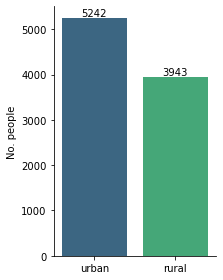

In [ ]:
variable_hists_vert(
    df_clean,
    "urban_rural",
    "",
    ["urban", "rural"],
    height=4,
    aspect=0.8,
    palette="viridis",
)


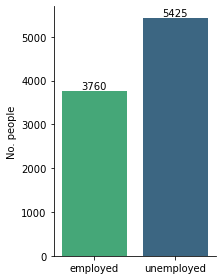

In [ ]:
variable_hists_vert(
    df_clean,
    "employed",
    "",
    ["employed", "unemployed"],
    height=4,
    aspect=0.8,
    palette="viridis_r",
)


In [ ]:
occupation_group_ordered_values = [
    "not working",
    "unskilled manual",
    "skilled manual",
    "household and domestic",
    "services",
    "agriculture - unskilled",
    "agricultural - unskilled",
    "agricultural - self employed",
    "agriculture - self employed",
    "clerical",
    "professional/technical/managerial",
]

In [ ]:
var_name = "occupation_group"

sns.catplot(
    y=var_name,
    data=df_clean,
    order=occupation_group_ordered_values,
    kind="count",
    palette="bone",
)

plt.xlabel("No. people")
plt.ylabel("")
plt.tight_layout()
plt.savefig(
    output_path + "Figs/Hists/" + var_name + ".png",
    dpi=300,
    facecolor="white",
    transparent=False,
)


ValueError: Could not interpret input 'occupation_group'

In [ ]:
ordered_wealth_brackets = ["poorest", "poorer", "middle", "richer", "richest"]

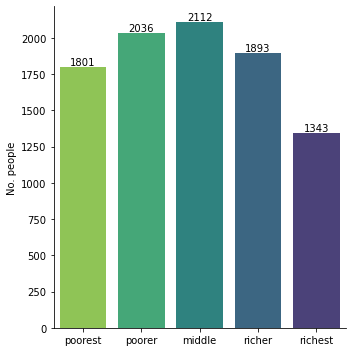

In [ ]:
variable_hists_vert(
    df_clean,
    "wealth_bracket",
    "",
    ["poorest", "poorer", "middle", "richer", "richest"],
    palette="viridis_r",
)


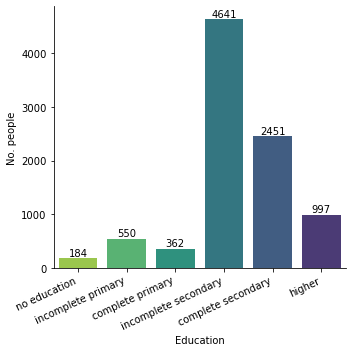

In [ ]:
education_attainment_ordered_values = [
    "no education",
    "incomplete primary",
    "complete primary",
    "incomplete secondary",
    "complete secondary",
    "higher",
]

variable_hists_vert(
    df_clean,
    "education_attainment",
    "Education",
    education_attainment_ordered_values,
    xticks_rotation=25,
    palette="viridis_r",
)


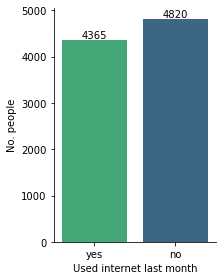

In [ ]:
variable_hists_vert(
    df_clean,
    "used_internet_last_month",
    "Used internet last month",
    ["yes", "no"],
    palette="viridis_r",
    height=4,
    aspect=0.8,
)


In [ ]:
ethnicity_values = [
    "black_slash_african",
    "coloured",
    "white",
    "indian_slash_asian",
    "other",
]


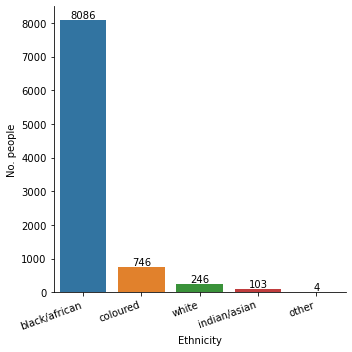

In [ ]:
variable_hists_vert(
    df_clean,
    "ethnicity",
    "Ethnicity",
    ethnicity_values,
    # palette='viridis',
    xticks_rotation=20,
    xticks=["black/african", "coloured", "white", "indian/asian", "other"],
)


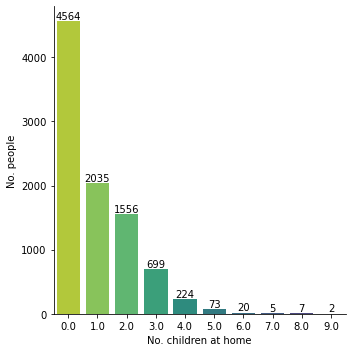

In [ ]:
variable_hists_vert(
    df_clean, "n_children_at_home", "No. children at home", None, palette="viridis_r"
)


##### Targets

In [ ]:
# var_name = 'last_hiv_test_facility'

# sns.catplot(
#     y=var_name,
#     data=df_clean,
#     kind='count',
#     palette='bone',
#     height=5,
#     aspect=1.5)

# plt.xlabel('No. people')
# plt.ylabel('Last HIV test facility')
# plt.tight_layout()
# plt.savefig(
#     output_path+'Figs/Hists/'+var_name+'.png',
#     dpi=300,
#     facecolor='white', transparent=False)

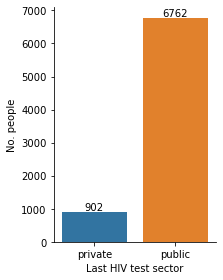

In [ ]:
variable_hists_vert(
    df_clean,
    "last_hiv_test_sector",
    "Last HIV test sector",
    ["private", "public"],
    height=4,
    aspect=0.8,
)


In [ ]:
# df_clean[(df_clean['last_hiv_test_sector']=='private')&(df_clean['ever_private']=='no')]

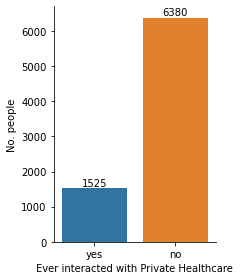

In [ ]:
variable_hists_vert(
    df_clean,
    "ever_private",
    "Ever interacted with Private Healthcare",
    ["yes", "no"],
    height=4,
    aspect=0.8,
)


https://seaborn.pydata.org/tutorial/categorical.html

## Correlations with target

### Target sample average

Last HIV test sector

In [ ]:
# df_select = df_clean[~(df_clean['last_hiv_test_sector']=='unknown')]
df_select = df_clean
# breakdown by private vs public
priv_pub_totals = df_select.groupby("ever_private").count().iloc[:, 0]
priv = priv_pub_totals["yes"]
pub = priv_pub_totals["no"]
# get avg percentage of private goers
avg_priv_perc = priv / (priv + pub) * 100
avg_priv_perc


19.291587602783046

In [ ]:
df_select.shape[0]

9185

Health Insurance

In [ ]:
# # breakdown by private vs public
# HI_totals = df_select.groupby('has_health_insurance').count().iloc[:,0]
# has_HI = HI_totals['yes']
# no_HI = HI_totals['no']
# # get avg percentage of private goers
# avg_HI_perc = has_HI/(has_HI+no_HI)*100
# avg_HI_perc

In [ ]:
# df_select.dropna().shape[0]

### Function to automate target-rates barchart creation

In [ ]:
def get_barplot_precentages(
    data,
    x,
    y,
    order=None,
    xlabel="",
    max=50,
    horizontal=None,
    palette="viridis_r",
    figsize=(3, 4),
    savefig=True,
    xticks_rotation=None,
    xticks=None,
):

    # set the necessary variables based on the target selected
    if y == "last_hiv_test_sector":
        pos_value = "private"
        avg_perc = avg_priv_perc
        ylabel = "% private HIV test"

    # elif y=='has_health_insurance':
    #     pos_value = 'yes'
    #     avg_perc = "health insurance avg not found!"
    #     ylabel = '% have health insurance'

    elif y == "ever_private":
        pos_value = "yes"
        avg_perc = avg_priv_perc
        ylabel = "% ever used private healthcare"
    else:
        raise ValueError("Target Unknown")

    # get n people per category
    x_totals = data.groupby(x)[y].count()
    # get break-down by "positive" and "negative" target value
    x_pos_neg_totals = data.groupby(x)[y].value_counts(sort=False)

    # get percentage pos
    df_percs = x_pos_neg_totals / x_totals * 100
    df_percs = df_percs.rename("percentage").reset_index()
    df_percs = df_percs[df_percs[y] == pos_value][[x, "percentage"]]
    df_percs = df_percs.round(1)

    # if horizontal graph, swap variables
    if horizontal == None:
        x_new, y_new = x, "percentage"
    else:
        x_new, y_new = "percentage", x
        xlabel, ylabel = ylabel, xlabel

    # plot
    plt.figure(figsize=figsize)
    ax = sns.barplot(
        x=x_new,
        y=y_new,
        data=df_percs,
        palette=palette,
        order=(order if order else None),
    )

    # add sample average line and set chart max count
    if horizontal == None:
        plt.axhline(
            avg_perc,
            c="grey",
            ls="--",
            label="Sample Average\n= " + str(np.round(avg_perc, 1)) + "%",
        )
        plt.ylim(0, max)
    else:
        plt.axvline(
            avg_perc,
            c="grey",
            ls="--",
            label="Sample Average\n= " + str(np.round(avg_perc, 1)) + "%",
        )
        plt.xlim(0, max)

    # add bar values
    plt.bar_label(ax.containers[0])

    # rotate xticks or relabel them
    if xticks_rotation:
        plt.xticks(rotation=xticks_rotation, ha="right")
    if xticks:
        locs, labels = plt.xticks()
        plt.xticks(locs, labels=xticks)

    # add legend
    plt.legend()
    # format
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()

    # save to file
    if savefig:
        plt.savefig(output_path + "Figs/Correlations/" + x + "_" + y + ".png", dpi=300)

    # return df_percs

### Features vs composite target

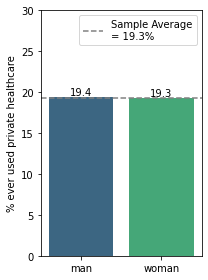

In [ ]:
get_barplot_precentages(df_select, "gender", "ever_private", max=30, palette="viridis")

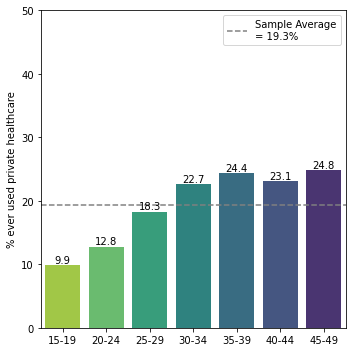

In [ ]:
get_barplot_precentages(
    df_select,
    "age_group",
    "ever_private",
    max=50,
    figsize=(5, 5),
    order=age_group_ordered_values,
)


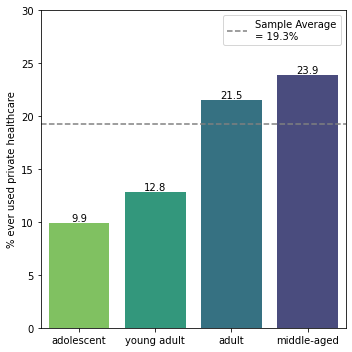

In [ ]:
get_barplot_precentages(
    df_select,
    "age_group_2",
    "ever_private",
    max=30,
    figsize=(5, 5),
    order=age_group_2_ordered_values,
)


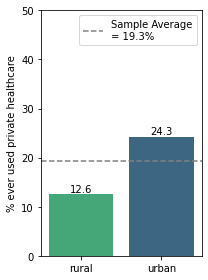

In [ ]:
get_barplot_precentages(df_select, "urban_rural", "ever_private", max=50)


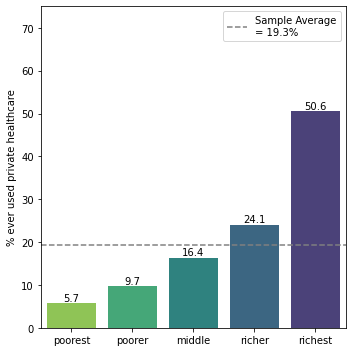

In [ ]:
get_barplot_precentages(
    df_select,
    "wealth_bracket",
    "ever_private",
    order=ordered_wealth_brackets,
    figsize=(5, 5),
    max=75,
)


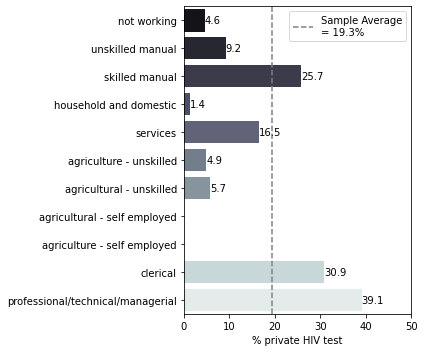

In [ ]:
get_barplot_precentages(
    df_select,
    "occupation_group",
    "last_hiv_test_sector",
    order=occupation_group_ordered_values,
    max=50,
    horizontal=True,
    figsize=(6, 5),
    palette="bone",
)


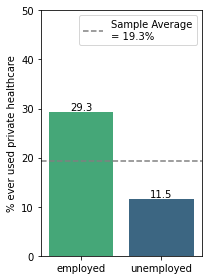

In [ ]:
get_barplot_precentages(df_select, "employed", "ever_private", max=50)


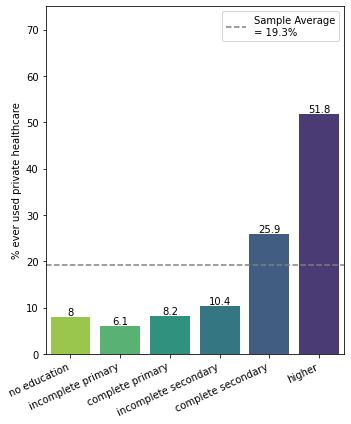

In [ ]:
get_barplot_precentages(
    df_select,
    "education_attainment",
    "ever_private",
    order=education_attainment_ordered_values,
    figsize=(5, 6),
    max=75,
    xticks_rotation=25,
)


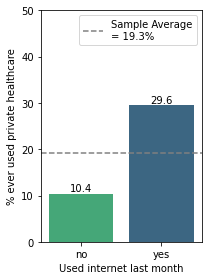

In [ ]:
get_barplot_precentages(
    df_select,
    "used_internet_last_month",
    "ever_private",
    xlabel="Used internet last month",
    max=50,
)


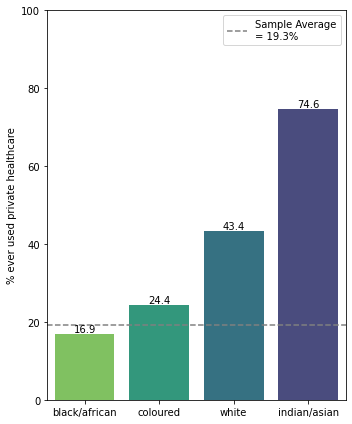

In [ ]:
get_barplot_precentages(
    df_select[df_select["ethnicity"] != "other"],
    "ethnicity",
    "ever_private",
    figsize=(5, 6),
    max=100,
    xticks=["black/african", "coloured", "white", "indian/asian"],
)


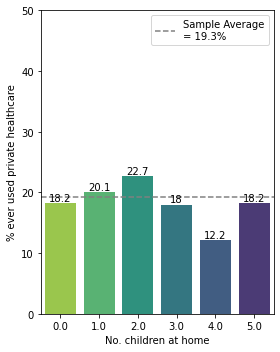

In [ ]:
get_barplot_precentages(
    df_select[df_select["n_children_at_home"] < 6],
    "n_children_at_home",
    "ever_private",
    xlabel="No. children at home",
    figsize=(4, 5),
)


# Etc.

In [ ]:
# # JUST GET RULES FOR LEAVES

# # function to get rules per segment (leaf nodes)
# # from sklearn.tree import _tree
# def get_leaf_node_rules(tree, feature_names):
#     # code from: 
#     # https://stackoverflow.com/questions/30408046/finding-a-corresponding-leaf-node-for-each-data-point-in-a-decision-tree-scikit
    
#     tree_ = tree.tree_
#     feature_name = [feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature]

#     paths = []
#     path = []
    
#     def recurse(node, path, paths):
#         if tree_.feature[node] != _tree.TREE_UNDEFINED:
#             name = feature_name[node]
#             threshold = tree_.threshold[node]
#             p1, p2 = list(path), list(path)
#             p1 += [f"({name} <= {np.round(threshold, 3)})"]
#             recurse(tree_.children_left[node], p1, paths)
#             p2 += [f"({name} > {np.round(threshold, 3)})"]
#             recurse(tree_.children_right[node], p2, paths)
#         else:
#             path += [(tree_.value[node], tree_.n_node_samples[node])]
#             paths += [path]    
    
#     recurse(0, path, paths)

#     # return paths

#     rules = []
#     for path in paths:

#         rule = []
#         condition = "if "
        
#         for p in path[:-1]:
#             if condition != "if ":
#                 condition += " and "
#             condition += str(p)
        
#         rule.append(condition)

#         rules.append(rule)
    
#     return rules

# get_leaf_node_rules(clf,X_df.columns)

## Random Forest (for importances)

In [112]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    # per split
    min_impurity_decrease=0.0002,
    # minimum segment (leaf) population
    min_weight_fraction_leaf=0.03, # equiv. to ~200 people per leaf

    random_state=0
    )
rf = rf.fit(
    X_df,
    y,
    sample_weight=sample_weights)

In [113]:
importances = pd.DataFrame(index=X_df.columns)
importances['Importance'] = rf.feature_importances_
importances.sort_values(by='Importance',inplace=True)

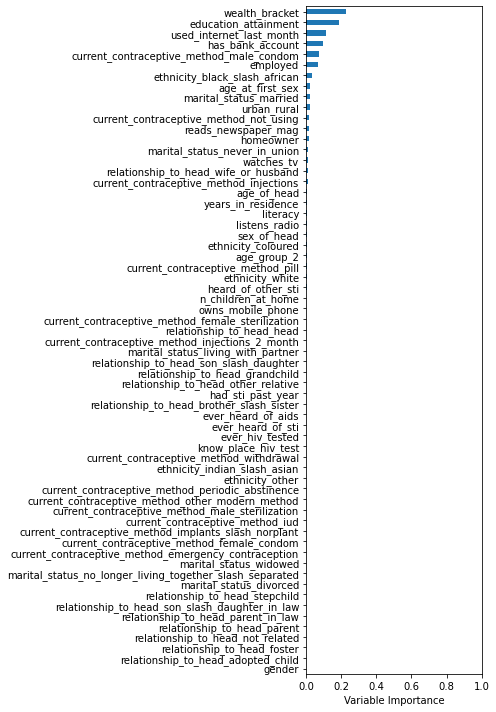

In [115]:
f,ax = plt.subplots(1,1,figsize=(7,10))
importances.plot.barh(legend=False,ax=ax)
plt.xlim(0,1)
plt.xlabel('Variable Importance')
plt.tight_layout()
plt.savefig(
    output_path+'Figs/rf_importances_weighted_new.png',
    dpi=300,
    facecolor='white', transparent=False)

In [116]:
# Dataset private baseline
y.mean()

0.19412115786332437

In [117]:
# test accuracy on private
y_test = y[y==1]
X_test = X_df[y==1]

rf.score(X_test,y_test)

0.15295926210607225

## Manual Decision Tree

In [ ]:
df_select = df[~(df['last_hiv_test_sector']=='unknown')]
df_select = df_select[['last_hiv_test_sector','gender','age_group_2','urban_rural','employed','wealth_bracket']]

In [ ]:
def get_decision_tree_df(variable_names:list, target_name='last_hiv_test_sector', multi_index=True, rounding=True):
    # total n people per group
    people_per_group = df_select.groupby(variable_names)[target_name].count().rename('n')
    people_per_group = pd.DataFrame(people_per_group)

    # those people split into private and public
    priv_pub_per_group = df_select.groupby(variable_names)[target_name].value_counts().rename('n')
    priv_pub_per_group = pd.DataFrame(priv_pub_per_group)

    # get priv/public percentage per group
    priv_pub_ratios = (priv_pub_per_group/people_per_group*100).reset_index()
    # rename for clarity
    priv_pub_ratios = priv_pub_ratios.rename({'n':'%_private'},axis=1)

    # only keep values for the private % and dispose of target column (no longer needed)
    result_df = priv_pub_ratios[priv_pub_ratios[target_name]=='private'].reset_index(drop=True).drop(target_name,axis=1)

    # add totals for each group back in
    result_df['n_total'] = people_per_group.reset_index()['n']

    if multi_index:
        result_df = result_df.set_index(variable_names)
    if rounding:
        result_df = result_df.round(1)
    return result_df

In [ ]:
select_vars = ['gender','urban_rural','employed']
get_decision_tree_df(select_vars)

%_private  n_total
gender urban_rural employed                      
man    rural       employed         19.6      393
                   unemployed        2.9      419
       urban       employed         27.3      666
                   unemployed        4.7      472
woman  rural       employed          9.9      912
                   unemployed        1.9     1894
       urban       employed         23.4     1575
                   unemployed        6.3     2109

In [ ]:
all_vars = ['gender','age_group_2','urban_rural','employed','wealth_bracket']
get_decision_tree_df(all_vars)

%_private  n_total
gender age_group_2 urban_rural employed   wealth_bracket                    
man    adolescent  rural       unemployed poorer                1.8        1
                                          richer               14.3        8
                   urban       unemployed richer                3.6        2
       adult       rural       employed   middle               25.0       37
                                          poorer               18.9       56
...                                                             ...      ...
woman  young adult urban       employed   richest              27.0      188
                               unemployed middle                0.7      286
                                          poorer                2.8      293
                                          richer                3.2       31
                                          richest              16.9        7

[100 rows x 2 columns]

In [ ]:
# from graphviz import Digraph
# f = Digraph('neato', format='jpg', encoding='utf8', filename='corleone', node_attr={'style': 'filled'},  graph_attr={"concentrate": "true", "splines":"ortho"})
# f.attr('node', shape='box')
# for index, row in df_tree.iterrows():
#   print(row[0])

## Municipality Rates
- Map (no. people per municipality in dataset)
- Map private rate

<AxesSubplot:>

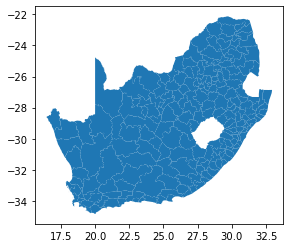

In [ ]:
municipalities_shapes_path = r'C:\Users\amira\OneDrive - University of Leeds\Projects\Palindrome\Market Segmentation\Data\UNOCHA SA Shapefiles\zaf_adm_sadb_ocha_20201109_shp\South Africa - Subnational Administrative Boundaries (OCHA)\\'
municipaities_shapes = gpd.read_file(municipalities_shapes_path+'zaf_admbnda_adm3_sadb_ocha_20201109.dbf')
# change file to zaf_admbnda_adm4_sadb_ocha_20201109.dbf for level-4 admin area
municipaities_shapes.rename({'ADM3_EN':'municipality'},axis=1,inplace=True)
municipaities_shapes.plot()

In [ ]:
munic_data_df = df.groupby('municipality').count().iloc[:,0].reset_index()
munic_data_df.columns = ['municipality','n_people']
munic_data_df

municipality  n_people
0       Abaqulusi        29
1     Alfred Duma        49
2       Amahlathi         2
3       Bela-Bela         6
4      Bergrivier         7
..            ...       ...
162    uMhlathuze        36
163       uMngeni         3
164     uMshwathi        16
165  uMuziwabantu        21
166     uPhongolo        12

[167 rows x 2 columns]

In [ ]:
# choose variable
x, y = 'municipality','last_hiv_test_sector'
# get n people per category
x_totals = df.groupby(x)[y].count()

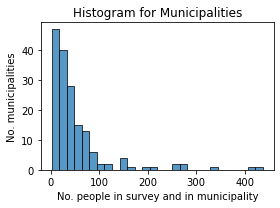

In [ ]:
plt.figure(figsize=(4,3))
sns.histplot(data=x_totals)
plt.title('Histogram for Municipalities')
plt.xlabel('No. people in survey and in municipality')
plt.ylabel('No. municipalities')
plt.tight_layout()
plt.savefig(output_path+'Figs/Hists/municipality_hist.png',dpi=300)

In [ ]:
# remove all municipalities with less that 100 people
x_totals[x_totals<100] = np.nan

In [ ]:
# get break-down by private/public
x_pub_priv_totals = df_select.groupby(x)[y].value_counts(sort=False)
# get percentage private
df_ratio = x_pub_priv_totals/x_totals*100
df_ratio = df_ratio.rename('percentage').reset_index()
df_priv_ratio = df_ratio[df_ratio[y]=='private'][[x,'percentage']]
#df_priv_ratio

In [ ]:
munic_data_df = munic_data_df.merge(df_priv_ratio)

In [ ]:
munic_data_geodf = municipaities_shapes.merge(munic_data_df, on='municipality', how='outer')

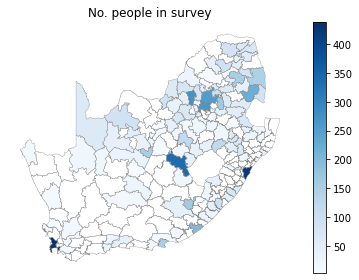

In [ ]:
f,ax=plt.subplots(1,1)
municipaities_shapes.boundary.plot(ax=ax, linewidth=0.3, edgecolor='grey')
munic_data_geodf.plot(column='n_people', cmap='Blues', legend=True, ax=ax, missing_kwds={'color':'white'})
plt.title('No. people in survey')
plt.axis('off')
plt.tight_layout()
plt.savefig(output_path+'Figs/Hists/map_n.png',dpi=300)

NameError: name 'municipaities_shapes' is not defined

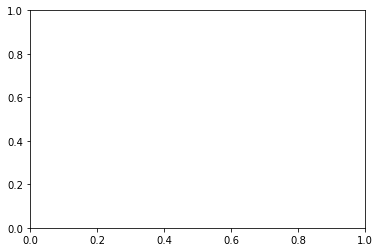

In [84]:
f,ax=plt.subplots(1,1)

municipaities_shapes.boundary.plot(ax=ax, linewidth=0.3, edgecolor='grey')

munic_data_geodf.plot(
    column='percentage', 
    vmin=0, vmax=25,
    cmap='viridis', 
    missing_kwds={
        "color": "white"},
        # "edgecolor": "white",
        # "hatch": "-/-/-/-",
        # "label": "Missing values",
        # },
    legend=True, ax=ax
)

plt.title('% Private')
plt.axis('off')
plt.tight_layout()
plt.savefig(output_path+'Figs/Correlations/map.png',dpi=300)

## Factor cluster visualisation

In [1]:
# # PCA PLOT CLUSTERS IN SPACE

# import prince

# famd_df = prince.FAMD(n_components=3, n_iter=300).fit_transform(X_df)
# famd_df['segment_ID'] = segment_ids
# famd_df

# # 2D:
# # sns.scatterplot(data=famd_df,x=0,y=1,hue='segment_ID')

# # 3D:
# import plotly.io as pio
# pio.renderers.default = "notebook"
# import plotly.express as px

# fig = px.scatter_3d(
#     famd_df, 
#     x=0, y=1, z=2, 
#     color='segment_ID',
#     # size_max=3, 
#     opacity=0.8
#     )

# # tight layout
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# fig.show()